# Testing the deployment
## Using gRPC for communicating with TF Serving

In [2]:
import numpy as np
import os
import grpc
import tensorflow as tf
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
from tensorflow.image import resize
from io import BytesIO
from urllib import request as req
from PIL import Image
from flask import Flask, request, jsonify

def download_image(url):
    with req.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def preprocessing_image(url, size):
    image = download_image(url)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = resize(image, size=size, method="nearest", antialias=True)
    return np.array([image], dtype=np.float32)/255.0

def np_to_protobuf(data):
    return tf.make_tensor_proto(data, shape=data.shape)

def make_request(image):
    pb_request = predict_pb2.PredictRequest()
    pb_request.model_spec.name = 'blood-cell-model'
    pb_request.model_spec.signature_name = 'serving_default'

    pb_request.inputs['inputs'].CopyFrom(np_to_protobuf(image))
    return pb_request
    
def process_response(pb_result):
    pred_clf = pb_result.outputs['classification'].float_val
    pred_sg = pb_result.outputs['segmentation'].float_val

    pred_clf = ['[Malignant] early Pre-B', '[Malignant] Pro-B', '[Malignant] Pre-B', 'Benign'][np.argmax(pred_clf)]
    pred_sg = (np.reshape(np.round(pred_sg), newshape=(192, 256, 1))*255.0).astype(np.uint8).tolist()
    
    return {"classification": pred_clf, "segmentation": pred_sg}

def apply_model(url):
    image = preprocessing_image(url=url, size=(192, 256))
    pb_request = make_request(image)
    pb_result = stub.Predict(pb_request, timeout=400.0)
    return process_response(pb_result)

host = os.getenv('TF_SERVING_HOST', 'localhost:8500')
channel = grpc.insecure_channel(host, options=(('grpc.enable_http_proxy', 0),))
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

## Examples

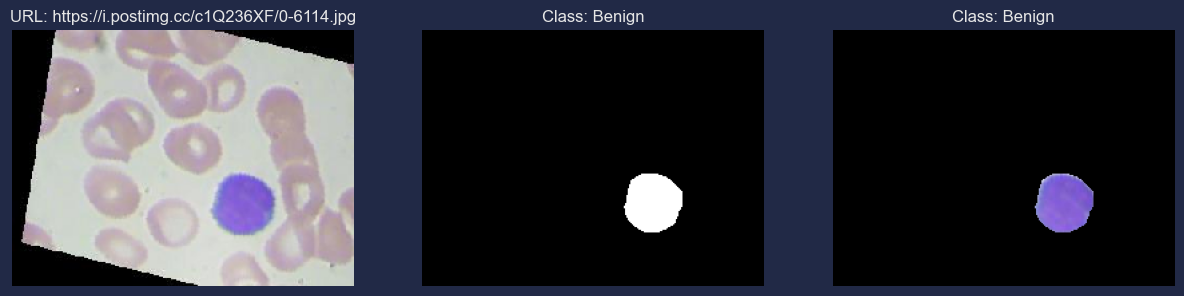

In [4]:
import matplotlib.pyplot as plt
import mplcyberpunk
import cv2
plt.style.use("cyberpunk")

def apply_mask(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

def predict(url):
    image = download_image(url)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = resize(image, size=(192, 256), method="nearest", antialias=True).numpy()

    pred = apply_model(url)

    class_ = pred["classification"]
    mask = np.array(pred["segmentation"], dtype=np.uint8)

    image_cropped = apply_mask(image, mask)

    plt.subplots(1, 3, figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"URL: {url}")
    plt.axis("off");

    plt.subplot(1, 3, 2)
    plt.imshow(pred["segmentation"], cmap="bone")
    plt.title(f"Class: {class_}")
    plt.axis("off");

    plt.subplot(1, 3, 3)
    plt.imshow(image_cropped, cmap="bone")
    plt.title(f"Class: {class_}")
    plt.axis("off");

url = "https://i.postimg.cc/c1Q236XF/0-6114.jpg"
predict(url)

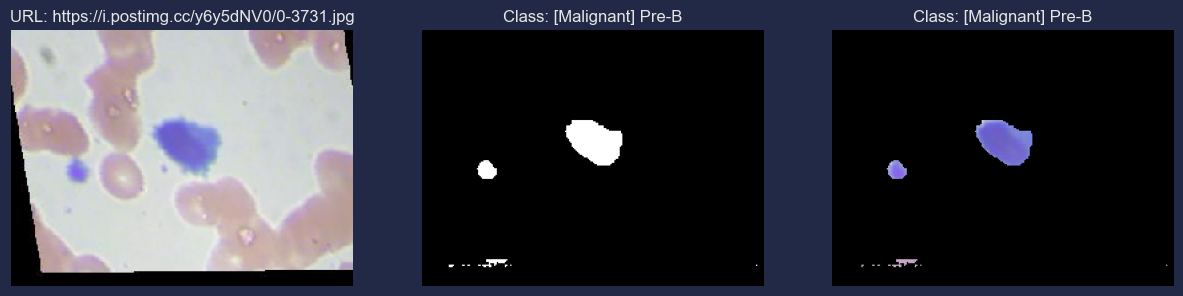

In [6]:
url = "https://i.postimg.cc/y6y5dNV0/0-3731.jpg"
predict(url)

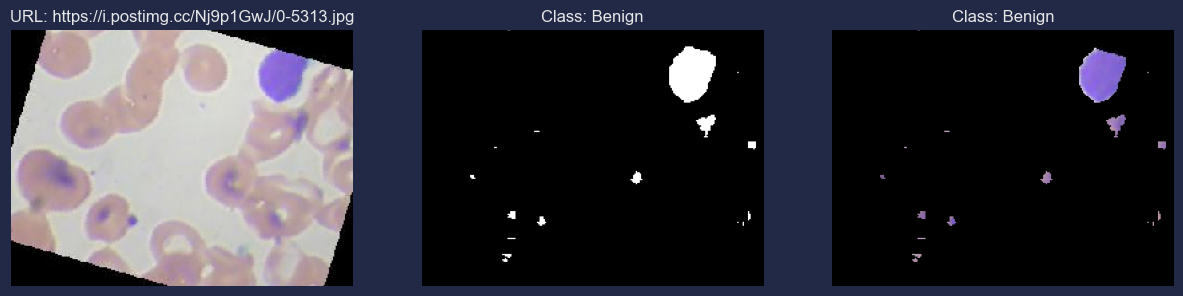

In [7]:
url = "https://i.postimg.cc/Nj9p1GwJ/0-5313.jpg"
predict(url)

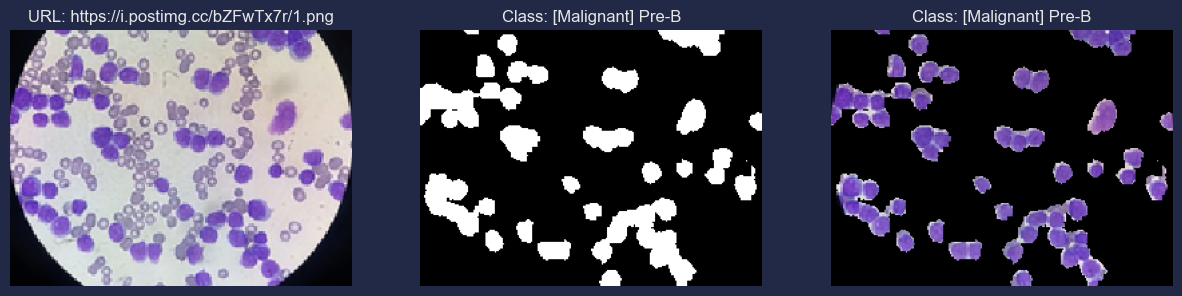

In [8]:
url = "https://i.postimg.cc/bZFwTx7r/1.png"
predict(url)

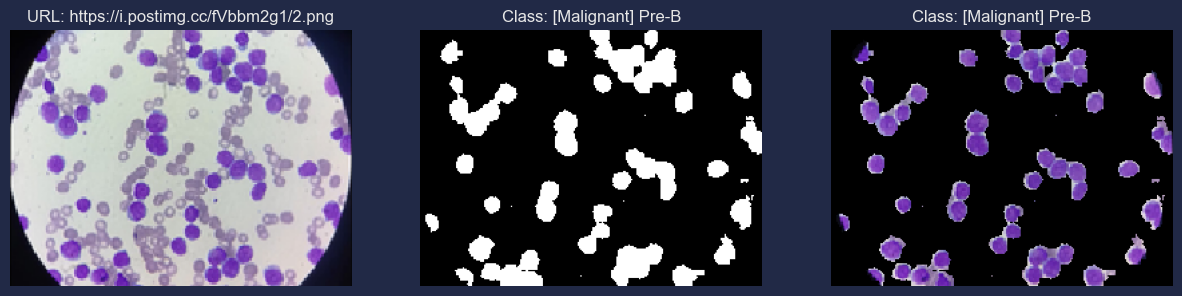

In [9]:
url = "https://i.postimg.cc/fVbbm2g1/2.png"
predict(url)